In [5]:
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [19]:
data_path =("/content/drive/MyDrive/datasets/dtsp/")
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels

In [20]:
TRAINING_DATA_DIR = str(data_path)
datagen_kwargs = dict(rescale=1./255, validation_split=.15)

In [21]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="validation", shuffle=True,target_size=IMAGE_SHAPE)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset="training",shuffle=True,target_size=IMAGE_SHAPE)

Found 210 images belonging to 2 classes.
Found 1190 images belonging to 2 classes.


In [22]:
print(train_generator.class_indices)
train_generator.image_shape
valid_generator.image_shape

{'original': 0, 'tampered': 1}


(224, 224, 3)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

In [32]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers

model = VGG16(weights='imagenet', include_top=False)
result = model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)
vgg16_transfer = Model(inputs=model.input, outputs=predictions)

vgg16_transfer.compile(loss='categorical_crossentropy',
                           optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                           metrics = ['accuracy',  
                                      AUC(name="auc"),
                                      Recall(thresholds=0.5),
                                      Precision(thresholds=0.5)])

58892288/58889256 [==============================] - 0s 0us/step


In [33]:
vgg16_transfer.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [36]:
for layer in model.layers:
	layer.trainable = False

output1=vgg16_transfer.get_layer('mixed7').output
model2=Model(vgg16_transfer.input,output1)
f_model=tf.keras.Sequential(
    [
     model2,
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=glorot_uniform(seed=0)),
     tf.keras.layers.Dropout(0.3,seed=0),
     tf.keras.layers.Dense(400, activation='relu',kernel_initializer=glorot_uniform(seed=0)),
     tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=glorot_uniform(seed=0)),
    ]
)

In [27]:
from keras.metrics import AUC,Precision,Recall
f_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy',AUC(name="auc"),Recall(thresholds=0.5),Precision(thresholds=0.5)])

In [38]:
from keras.metrics import AUC,Precision,Recall
vgg16_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy',AUC(name="auc"),Recall(thresholds=0.5),Precision(thresholds=0.5)])
history_pretrained = vgg16_transfer.fit_generator(train_generator,epochs=15, shuffle = True,  verbose = 1,validation_data = valid_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
38/38 [==============================] - 685s 18s/step - loss: 0.6377 - binary_accuracy: 0.6251 - auc: 0.6910 - recall_6: 0.6204 - precision_6: 0.6262 - val_loss: 0.6731 - val_binary_accuracy: 0.6524 - val_auc: 0.6445 - val_recall_6: 0.6476 - val_precision_6: 0.6538
Epoch 2/15
38/38 [==============================] - 683s 18s/step - loss: 0.6031 - binary_accuracy: 0.6871 - auc: 0.7756 - recall_6: 0.6881 - precision_6: 0.6868 - val_loss: 0.6535 - val_binary_accuracy: 0.6762 - val_auc: 0.7118 - val_recall_6: 0.6667 - val_precision_6: 0.6796
Epoch 3/15
38/38 [==============================] - 683s 18s/step - loss: 0.5653 - binary_accuracy: 0.7333 - auc: 0.8116 - recall_6: 0.7323 - precision_6: 0.7339 - val_loss: 0.6438 - val_binary_accuracy: 0.6357 - val_auc: 0.6950 - val_recall_6: 0.7000 - val_precision_6: 0.6203
Epoch 4/15
38/38 [==============================] - 683s 18s/step - loss: 0.5505 - binary_accuracy: 0.7552 - auc: 0.8289 - recall_6: 0.7612 - precision_6: 0.7521 - va

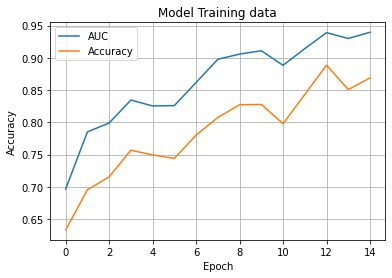

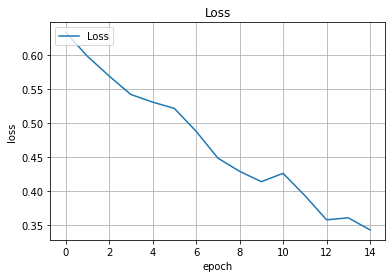

In [41]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['auc'])
plt.plot(history_pretrained.history['binary_accuracy'])
plt.title('Model Training data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['AUC','Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Loss'], loc='upper left')
plt.show()

In [45]:
vgg16_transfer.save('/content/drive/My Drive/datasets/VGG16_imageforgery')

INFO:tensorflow:Assets written to: /content/drive/My Drive/datasets/VGG16_imageforgery/assets


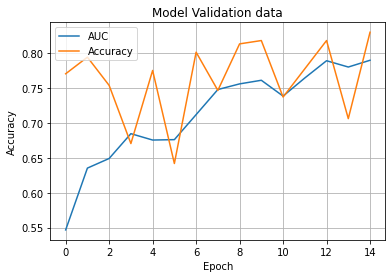

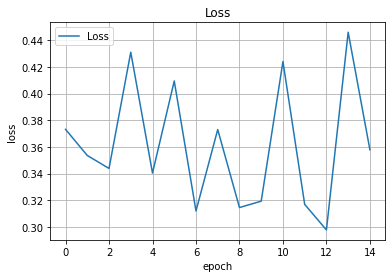

In [77]:
# summarize history for accuracy
plt.plot(history_pretrained.history['val_auc'])
plt.plot(history_pretrained.history['val_binary_accuracy'])
plt.title('Model Validation data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['AUC','Accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Loss'], loc='upper left')
plt.show()